Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

Предлогаю такой план:

Подшаг 1:

    1. посмотреть на данные, тип данных, предположить какие признаки наиболее актуальны, а какие очевидно лишние.
    2. определить количество пропусков, если имеются, то решить как заполнять, какие можно удалить.
    3. имеются ли дубликаты, решить - могут ли быть дубликаты, стоит их удалять или оставить.
    4. посмотреть на выбивающиеся данные - выбросы, изучив распределение признаков.

Подшаг 2:

    1. закрыть вопрос с пропусками.
    2. закрыть вопрос с типом данных, привести все признаки к подходящему типу.
    3. исключить выбросы.
    
Подшаг 3:

    1. Категориальные данные требуют обработки, к примеру ОНЕ или Ordinal Encording.
    2. Разделение общей выборки на тренировочную, валидационную и тестовую.
    2. Масштабирование, если оно потребуется.

**НАБОР ИНСТРУМЕНТОВ**


In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder


### Подшаг 1

                                                ** 1 **
                                            
общий взгляд на данные с общими выводами

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data.dtypes.value_counts()

object    9
int64     7
dtype: int64

**9** катеориальных признаков типа object, среди которого находится дата подачи объявления о продаже автомобиля, который следует изменить в тип объекта даты.

и **7** целочисленных

In [6]:
data.select_dtypes(include = ['int64']).head(3)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
0,480,1993,0,150000,0,0,70435
1,18300,2011,190,125000,5,0,66954
2,9800,2004,163,125000,8,0,90480


здесь мы видим следующие целочисленные признаки:
    
    цена (целевой признак)
    
    год регистрации автомобиля
    
    мощность (л.с.)
    
    пробег
    
    месяц регистрации (по моему мнению - бесполезный признак, который стоит удалить)
    
    количество фотографий автомобиля (на характеристики автомобиля не влияет, но важно для внимания, оценки, психологических аспектов покупателя. Стоит оставить.
    
    почтовый индекс продавца - на характеристики и качество автомобиля не влияет, но может укаазывать на продавца, регион, где идёт продажа, и среднюю цену в данном регионе.Возможно один автомобиль будет иметь разную цену в разных регионах в зависимости от предложения и спроса.

In [7]:
data.select_dtypes(include = ['object']).head(3)

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,2016-03-24 11:52:17,NaN,manual,golf,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,coupe,manual,NaN,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,suv,auto,grand,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46


здесь мы видим следующие категориальные (в большей своей части) признаки:

        дата скачивания объявления из базы (абсолютно ненужный признак, который будет удален)
        
        тип автомобильного кузова
        
        тип коробки
        
        модель автомобиля
        
        тип топлива
        
        брэнд
        
        был ли ремонт автомобиля (мной воспринимается как признак, отражающий ДТП, после которого был восстанавливающий ремонт, иными словами - был автомобиль в ДТП или нет)
        
        дата публикации (создания) объявления, признак для нашей цели также неактуален, т.к. поправки на инфляцию не будет, хотя можно выделить год в отдельный признак, чтобы модель могла его учесть.
        
        дата последней активности пользователя (также абсолютно ненужный признак для нашей цели, т.к. факт активности пользователя не влияет и не должен влиять на стоимость автомобиля, его можно использовать для других целей - например снятие объявления с доски, если пользователь некоторое время (договоренное время при регистрации) не появлялся на данном интернет-ресурсе).

__Вывод__

Посмотрели на имеющиеся признаки, определили какие стоит удалить:
    
    месяц регистрации автомобиля.
    дата скачиывния объявления из базы.
    дата последней активности пользователя.
    индекс продающего - решу позже оставлять или удалить, или неким образом сгруппировать.
   



                                                ** 2 **
                                                
посмотрим на наличие пропусков и попробуем решить что с ними делать.

посмотрим на количесвто пропусков в процентном содержании.

In [8]:
df1 = data.isna().sum() / len(data)
df1.sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
LastSeen             0.000000
PostalCode           0.000000
NumberOfPictures     0.000000
DateCreated          0.000000
Brand                0.000000
RegistrationMonth    0.000000
Kilometer            0.000000
Power                0.000000
RegistrationYear     0.000000
Price                0.000000
DateCrawled          0.000000
dtype: float64

5 признаков содержат пропуски и все они категориальные:
    
    факт ремонта - 20%
    тип кузова - 10%
    тип топлива - 9%
    тип коробки передач - 5%
    модель - 5%

Какие пути решения могут быть?

объекты, содержащие пропус в признаке "Модель" - удалить, т.к. покупатель не знает что он покупает, информация об автомобиле критичная.

Для определения тактики работы с другими признаками - посмотрим их подробнее - посмотрим какие категории имеются.

Зная, что автомобиль одного брэнда и модели, одного года выпуска (не то, что регистрации, а даже выпуска) может иметь разные тип кузова, коробку передач и тип топливаа, то заполнить пропуски корректно не получится. Т.к. это категориальные данные, введу еще одну категорию - __"unknown"__, которая заполнит пропуски, чтобы не удалять объекты.

                                                ** 3 **
                                                
определим наличие дубликатов и решим что будем с ними делать.

In [112]:
data.duplicated().sum()

0

In [9]:
data.duplicated().count()

354369

In [10]:
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Не знаю почему он посчитал все объекты с разными признаками как дубликат.

Дубликатов нет.

                                             ***** 4 *****
                                                
посмотрим на распределения целочисленных признаков и попробуем найти выбросы.

1. цена (целевой признак)

2. год регистрации автомобиля

3. мощность (л.с.)

3. пробег

4. количество фотографий автомобиля (просто посмотрим на максимальное значение)

                                           ***** 4.1.*****

**Цена (в евро)**

Text(0, 0.5, 'количество')

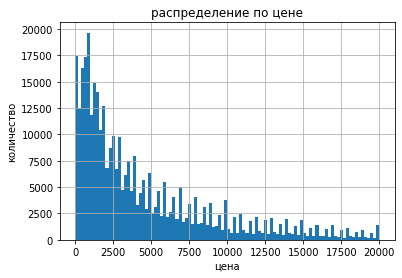

In [11]:
data['Price'].hist(bins=100)
plt.title('распределение по цене')
plt.xlabel('цена')
plt.ylabel('количество')

Хм. Почти экспоненциальное распределение.

In [12]:
df1 = data.loc[data['Price'] < 2000]

In [13]:
len(df1)

147266

Text(0, 0.5, 'количество')

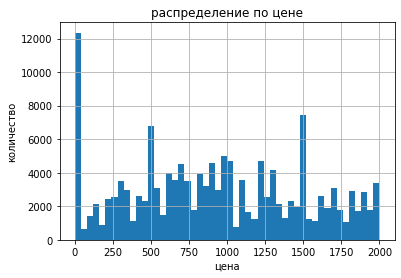

In [14]:
df1['Price'].hist(bins=50)
plt.title('распределение по цене')
plt.xlabel('цена')
plt.ylabel('количество')

In [15]:
df1.loc[df1['Price'] == 0].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10


цена в 0 евро - явный выброс, полагаю, что такой автомобиль действительно могли выставить на доске объявлений и указать цену в 0 евро, но при личном разговоре её резко увеличить, т.к. при продаже авто частями или просто в металлолом сдать - выйдет больше, или же возможно собственник таким образом хочет просто избавиться от лишнего груза, просто чтобы кто-то забрал неисправное авто. 

Ещё раз - считаю, что такая цена внесет шум в модель, и ее RMSE не будет минимальной.

К тому же недопустимо, чтобы наша рекомендательная модель оценивала выставляемы продавцом автомобиль в 0 или 10 евро. 

нужно ответить на вопрос - кукую цену мы примем за минимальную.

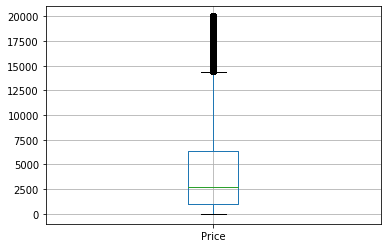

In [16]:
data.boxplot(column=['Price'])

In [17]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

среднее арифметическое больше медианы в 1,6 раза (4416 и 2700 соответственно), в выборке есть автомоблили с завышенной ценой или слишком много, как мы увидели из распределения, автомобилей с ценой около нуля, или и то и другое.

In [18]:
len(data.loc[data['Price'] > 15000])/len(data)

0.04199295085066696

Посмотрели на разброс цены.

Недопустимо оставлять для модели в обучающей выборке объекты стоимостью 0 евро, хотя бы из простых размышлений, что модельь не должна оценивать автомобиль в 0 евро каким бы он ни был.

                                         ***** 4.2.*****
**Год регистрации автомобиля.**

In [19]:
len(data['RegistrationYear'].unique())

151

In [20]:
len(data)

354369

In [21]:
data['RegistrationYear'].value_counts().tail(5)

3200    1
1920    1
1919    1
1915    1
8455    1
Name: RegistrationYear, dtype: int64

In [22]:
year = data.groupby(['RegistrationYear']).count()

Text(0, 0.5, 'количество зарегистрированных объектов ')

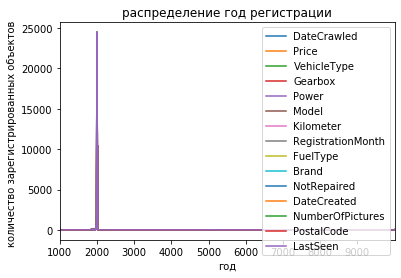

In [23]:
year.plot()
plt.title('распределение год регистрации')
plt.xlabel('год')
plt.ylabel('количество зарегистрированных объектов ')

есть почти в единичном количестве все года, которых не должно быть.

In [24]:
data['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Мы видим в признаке "год регистрации" числа от 1000 до 9999, которые не могут отражать действительность и подлежат исключению из датафрейма.

Во избежание повтора подобной ситуации - стоит установить ограничения не на 4х значное число, а ещё на его диапозон.

А пока мы просто исключим из датафрейма объекты, у которых указан год < 1936, т.к. именно с этого года была организована служба ГИБДД, где и проходила регистрации транспортных средств.

In [25]:
len(data.loc[data['RegistrationYear'] < 1936])

200

удалим 200 объектов

                                    *****4.3.*****
                                    
**Mощность (л.с.)**

Text(0, 0.5, 'кмощность')

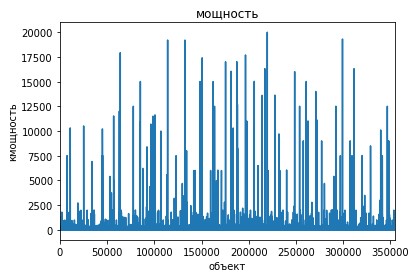

In [26]:
data['Power'].plot()
plt.title('мощность')
plt.xlabel('объект')
plt.ylabel('кмощность')

мы видим на графике, что есть объекты с нереально высоким значением мощности двигателя.

In [27]:
data['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

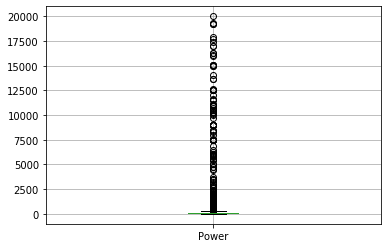

In [28]:
data.boxplot(['Power'])

Максимальная мощность двигателя автомобиля на сегодняшний день - 5000 л.с. Производство этих суперкаров не поставлено на поток и их количество ограничено. Врядли их будут продавать на сайте, где можно купить автомобиль за 0евро. 

Стоит удалить все объекты, у которых указана мощность свыше 5000л.с. и поставить ограничение в заполняемом пользователем признаке "Power" до 5000 как максимум - однозначно, может даже и менее 5000.


In [29]:
len(data.loc[data['Power'] > 5000])/len(data)

0.00023139721589642435

                                    *****4.4.*****

**Пробег**

Text(0, 0.5, 'количество автомобилей с данным пробегом')

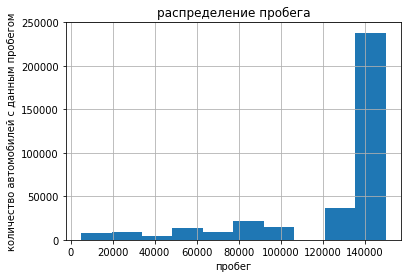

In [30]:
data['Kilometer'].hist()
plt.title('распределение пробега')
plt.xlabel('пробег')
plt.ylabel('количество автомобилей с данным пробегом')

In [31]:
data['Kilometer'].describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Странно получается - очень много автомашин с пробегом (более 50% объектов) в 150т.км. Как-будто это предел.

                                ***** 4.5.*****
                                
**Kоличество фотографий автомобиля**

In [32]:
data['NumberOfPictures'].describe()

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

У всех объектов 0 фотографий. Соответственно удалим этот признак сейчас же. Хотя идея повысить цену при наличии 2х фотографий на 1% от стоимости - стимулировала бы пользователей выкладывать больше, максимально возможное количество фотографий. Хотя этот признак с точки зрения логики должен коррелировать с бOльшим откликом, отзывчивостью среди покупателей.

In [33]:
data = data.drop(['NumberOfPictures'], axis=1)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


### Подшаг 2

                                ***** 1.*****
                                
**Избавляемся от пропусков**

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


In [36]:
df1 = data.isna().sum() / len(data)
df1.sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
LastSeen             0.000000
PostalCode           0.000000
DateCreated          0.000000
Brand                0.000000
RegistrationMonth    0.000000
Kilometer            0.000000
Power                0.000000
RegistrationYear     0.000000
Price                0.000000
DateCrawled          0.000000
dtype: float64

В признаке NotRepaired мы решили ввести третью категорию - unknown.

Сделаем это.

In [37]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

In [38]:
data['NotRepaired'].value_counts()

no         247161
unknown     71154
yes         36054
Name: NotRepaired, dtype: int64

Следующий признак с пропусками, который мы обрабтаем - VehicleType.

In [39]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

У меня есть категория "другие", можно ли туда забросить все пропуски в этом признаке? Думаю, что да. Возможно это привнесет некий шум в данные, т.к. в других окажется седан, хотя под него есть категория. Но если создать категорию unknown, то по сути она будет дублировать other.

Приступим.

In [40]:
data['VehicleType'] = data['VehicleType'].fillna('other')

In [41]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: VehicleType, dtype: int64

Следующий признак с пропусками, который мы обрабтаем - FuelType.

In [42]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Решим проблему аналогичным образом, как сделали это с VehicleType.

In [43]:
data['FuelType'] = data['FuelType'].fillna('other')

In [44]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: FuelType, dtype: int64

Следующим признак с пропусками, который мы обработапм - Gearbox

In [45]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

2 варианта заполнения - ручная или автоматическая коробка передач.

Поэтому введем третью категорию - unknown.

In [46]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

In [47]:
data['Gearbox'].value_counts()

manual     268251
auto        66285
unknown     19833
Name: Gearbox, dtype: int64

Следующий признак с пропусками - Model

In [48]:
len(data['Model'].unique())

251

251 типов моделей.

In [49]:
len(data.loc[data['Model'] == 'other'])

24421

Закинем пропуски в признаке Model в категорию other. 

In [50]:
data['Model'] = data['Model'].fillna('other')

In [51]:
data['Model'].value_counts().head(10)

other       44126
golf        29232
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
Name: Model, dtype: int64

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null object
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


Пропуски заполнены.

Идём дальше - избавимся от лищних признаков, которые мы ещё не удалили. Изменим тип данных там, где это необходимо

                                        ***** 2.*****

**Закроем вопрос с типом данных, приведём все признаки к подходящему типу.**

Но прежде удалим признаки, которые ранее определили, как не несущие информации и мешающие, создающие шумы, а именно:

    DateCrawled
    RegistrationMonth
    DateCreated 
    PostalCode
    LastSeen 
    

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null object
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


In [54]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         354369 non-null object
RegistrationYear    354369 non-null int64
Gearbox             354369 non-null object
Power               354369 non-null int64
Model               354369 non-null object
Kilometer           354369 non-null int64
FuelType            354369 non-null object
Brand               354369 non-null object
NotRepaired         354369 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Оставили только рабочие признаки и целевой.

                                    ***** 3.*****

**Исключим выбросы.**

            1. Price

Сайт drom.ru предлагает в качестве минимальной цены стоимость в 6т.р.

In [56]:
6000/70

85.71428571428571

это примерно 85 евро по среднему курсу 2016 года.

Причем это автомобиль, прошедший их оценку. В качестве ориентира предлагаю убрать объекты, в которых указанная стоимость менее 85 евро (хотя я увеличил бы минимальную стоимость автомобиля, хотя бы до 10т.р. или 150 евро, если предположим 1 евро=70р.)

In [57]:
150*70

10500

Посмотрим какой процент объектов попадает под разные ценовые категории.

    до 85 евро

In [58]:
len(data.loc[data['Price'] < 85]) / len(data)

0.03706306138516631

    до 100 евро

In [59]:
len(data.loc[data['Price'] < 100]) / len(data)

0.03757100649323163

    до 150 евро

In [60]:
len(data.loc[data['Price'] < 150]) / len(data)

0.04213122479675141

Предлагаю определить минимальную цену за автомобиль в 150 евро, исключив объекты дешевле 150 евро

In [61]:
data = data.loc[data['Price'] >= 150]

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339439 entries, 0 to 354368
Data columns (total 10 columns):
Price               339439 non-null int64
VehicleType         339439 non-null object
RegistrationYear    339439 non-null int64
Gearbox             339439 non-null object
Power               339439 non-null int64
Model               339439 non-null object
Kilometer           339439 non-null int64
FuelType            339439 non-null object
Brand               339439 non-null object
NotRepaired         339439 non-null object
dtypes: int64(4), object(6)
memory usage: 28.5+ MB


In [63]:
data['Price'].describe()

count    339439.000000
mean       4610.187881
std        4514.961005
min         150.000000
25%        1200.000000
50%        2900.000000
75%        6550.000000
max       20000.000000
Name: Price, dtype: float64

            2.Power

Как мы сказали ранее, максимальная мощность автомобилей на сегодняшний день - 5000 л.с.

Поэтому удалим объекты с мощностью выше 5000 л.с.

In [64]:
data = data.loc[data['Power'] <= 5000]

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339363 entries, 0 to 354368
Data columns (total 10 columns):
Price               339363 non-null int64
VehicleType         339363 non-null object
RegistrationYear    339363 non-null int64
Gearbox             339363 non-null object
Power               339363 non-null int64
Model               339363 non-null object
Kilometer           339363 non-null int64
FuelType            339363 non-null object
Brand               339363 non-null object
NotRepaired         339363 non-null object
dtypes: int64(4), object(6)
memory usage: 28.5+ MB


In [66]:
data.tail(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no
354368,3400,wagon,2002,manual,100,golf,150000,gasoline,volkswagen,unknown


In [67]:
data = data.reset_index()

### Подшаг 3

            1. Подготовка категориальных данных

Из двух способов подготовки категориальных данных:

    1. One Hot Encording
    2. Ordinal Encording
    
Первый (One Hot Encording) подходит для следующих признаков:

    VehicleType
    Gearbox
    FuelType
    NotRepaired

Т.к. тут небольшое количество категорий.

Второй (Ordinal Encording) для:

    Model
    Brand
    
Здесь категорий много, поэтому мы выберем второй способ обработки категориальных признаков - Ordinal Encording.

In [68]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data[['Brand', 'Model', 'FuelType', 'Gearbox', 'VehicleType', 'NotRepaired']]))

In [69]:
data_ordinal

,0,1,2,3,4,5
0,38.0,116.0,6.0,1.0,3.0,1.0
1,1.0,166.0,2.0,1.0,2.0,2.0
2,14.0,117.0,2.0,0.0,6.0,1.0
3,38.0,116.0,6.0,1.0,5.0,0.0
4,31.0,101.0,2.0,1.0,5.0,0.0
...,...,...,...,...,...,...
339358,24.0,249.0,6.0,1.0,0.0,0.0
339359,33.0,166.0,5.0,2.0,3.0,1.0
339360,32.0,106.0,6.0,0.0,1.0,0.0
339361,38.0,224.0,2.0,1.0,0.0,0.0


In [70]:
data['Brand'] = data_ordinal[0]
data['Model'] = data_ordinal[1]
data['FuelType'] = data_ordinal[2]
data['Gearbox'] = data_ordinal[3]
data['VehicleType'] = data_ordinal[4]
data['NotRepaired'] = data_ordinal[5]


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339363 entries, 0 to 339362
Data columns (total 11 columns):
index               339363 non-null int64
Price               339363 non-null int64
VehicleType         339363 non-null float64
RegistrationYear    339363 non-null int64
Gearbox             339363 non-null float64
Power               339363 non-null int64
Model               339363 non-null float64
Kilometer           339363 non-null int64
FuelType            339363 non-null float64
Brand               339363 non-null float64
NotRepaired         339363 non-null float64
dtypes: float64(6), int64(5)
memory usage: 28.5 MB


In [72]:
data

,index,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,0,480,3.0,1993,1.0,0,116.0,150000,6.0,38.0,1.0
1,1,18300,2.0,2011,1.0,190,166.0,125000,2.0,1.0,2.0
2,2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0
3,3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0
4,4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
339358,354363,1150,0.0,2000,1.0,0,249.0,150000,6.0,24.0,0.0
339359,354365,2200,3.0,2005,2.0,0,166.0,20000,5.0,33.0,1.0
339360,354366,1199,1.0,2000,0.0,101,106.0,125000,6.0,32.0,0.0
339361,354367,9200,0.0,1996,1.0,102,224.0,150000,2.0,38.0,0.0


Изменим тип данных с float на int

In [73]:
col = data.columns

In [74]:
for i in range(len(col)):
    if data[col[i]].dtype == 'int64':
        i+=1
    else:
        data[col[i]] = data[col[i]].astype('int64')

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339363 entries, 0 to 339362
Data columns (total 11 columns):
index               339363 non-null int64
Price               339363 non-null int64
VehicleType         339363 non-null int64
RegistrationYear    339363 non-null int64
Gearbox             339363 non-null int64
Power               339363 non-null int64
Model               339363 non-null int64
Kilometer           339363 non-null int64
FuelType            339363 non-null int64
Brand               339363 non-null int64
NotRepaired         339363 non-null int64
dtypes: int64(11)
memory usage: 28.5 MB


Перед масштабированием нам нужно сделать:

    1. иключить признак "Price", чтобы он остался неизенным
    2. Разделить выборку на обучающую, валидационную и тестовую.
    3. Обучить наш scaler на обучающей выборке и применить к валидационной и тестовой.
    
Тогда наши данне будут готовы к шагу 2.

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339363 entries, 0 to 339362
Data columns (total 11 columns):
index               339363 non-null int64
Price               339363 non-null int64
VehicleType         339363 non-null int64
RegistrationYear    339363 non-null int64
Gearbox             339363 non-null int64
Power               339363 non-null int64
Model               339363 non-null int64
Kilometer           339363 non-null int64
FuelType            339363 non-null int64
Brand               339363 non-null int64
NotRepaired         339363 non-null int64
dtypes: int64(11)
memory usage: 28.5 MB


                 *** Разделение общей выборки на подвыборки и целевой признак ***



In [77]:
target = data[['Price']]
features = data[['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'RegistrationYear']]

In [78]:
len(target)

339363

In [79]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339363 entries, 0 to 339362
Data columns (total 9 columns):
VehicleType         339363 non-null int64
Gearbox             339363 non-null int64
Power               339363 non-null int64
Model               339363 non-null int64
Kilometer           339363 non-null int64
FuelType            339363 non-null int64
Brand               339363 non-null int64
NotRepaired         339363 non-null int64
RegistrationYear    339363 non-null int64
dtypes: int64(9)
memory usage: 23.3 MB


In [80]:
features_train, features_general, target_train, target_general = train_test_split(
    features, target, test_size=0.40, random_state=123)

In [81]:
features_train.shape, features_general.shape, target_train.shape, target_general.shape

((203617, 9), (135746, 9), (203617, 1), (135746, 1))

In [82]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_general, target_general, test_size=0.50, random_state=123)

In [83]:
features_valid.shape, features_test.shape, target_valid.shape, target_test.shape

((67873, 9), (67873, 9), (67873, 1), (67873, 1))

Разделили, проверли, что всё верно. Идём дальше. К масштабированию.

                            *** Масштабирование признаков ***

Определим признаки, которые будем масштабировать:

In [84]:
numeric = ['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'RegistrationYear']

обучим наш scaler

In [85]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])


StandardScaler(copy=True, with_mean=True, with_std=True)

и преобразуем наши выборки

In [86]:
features_train[numeric] = scaler.transform(features_train[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [87]:
features_valid[numeric] = scaler.transform(features_valid[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [88]:
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Мы посмотрели на данные, удалили ненужные признаки, исключили объекты с нелепыми значениями, провели Ordinal Encording для категориальных признаков, разбили общую выборку на тренировочную, валидационную и тестовую, провели масштабирование. 

И готовы к обучению моделей.

# 2. Обучение моделей

В этом шаге мы попробуем обучить 4 модели:

    1. Линейная регрессия
    2. Решающее дерево
    3. Случайный лес
    4. Light GBM 

                               *** Линейная регрессия ***

In [89]:
from sklearn.linear_model import LinearRegression

In [90]:
regr = LinearRegression()

In [91]:
%%time
regr.fit(features_train, target_train)

CPU times: user 66 ms, sys: 4.16 ms, total: 70.1 ms
Wall time: 57.2 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
%%time
pred_reg_val = regr.predict(features_valid)

CPU times: user 14.9 ms, sys: 722 µs, total: 15.6 ms
Wall time: 6.53 ms


In [93]:
rmse_reg_val = (mse(target_valid, pred_reg_val))**0.5

In [94]:
rmse_reg_val 

3374.073872722461

rmse = 3374

время на обучение = 57 милисек.

время на прогноз = 6.08 милисек.

                                *** Решающее дерево ***

In [95]:
from sklearn.tree import DecisionTreeRegressor

**без листьев**

In [96]:
%%time

rmse_min = 100500

for depth in range(1, 21, 1):
    tree = DecisionTreeRegressor(random_state = 123, max_depth=depth)
    tree.fit(features_train, target_train)
    pred = tree.predict(features_valid)
    
    rmse = (mse(target_valid, pred))**0.5
        
    if rmse < rmse_min:
        rmse_min = rmse
        depth_best = depth

CPU times: user 9.96 s, sys: 0 ns, total: 9.96 s
Wall time: 10 s


In [97]:
%%time
tree1 = DecisionTreeRegressor(random_state = 123, max_depth=depth_best)
tree1.fit(features_train, target_train)


CPU times: user 684 ms, sys: 0 ns, total: 684 ms
Wall time: 694 ms


DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=123, splitter='best')

In [98]:
%%time

pred1 = tree1.predict(features_valid)
    
print('max_depth:', depth_best)
print('rmse:', (mse(target_valid, pred))**0.5)

max_depth: 15
rmse: 2057.93395470199
CPU times: user 22.8 ms, sys: 0 ns, total: 22.8 ms
Wall time: 33.3 ms


rmse = 2057

время на обучение = 689 милисек.

время на прогноз = 21 милисек.

**с листьями**

In [99]:
%%time

rmse_min = 100500

for nodes in range(2, 30, 1):
    for depth in range(2, 20, 1):
        tree2 = DecisionTreeRegressor(random_state = 123, max_depth=depth, max_leaf_nodes=nodes)
        tree2.fit(features_train, target_train)
        pred2 = tree2.predict(features_valid)
    
        rmse1 = (mse(target_valid, pred2))**0.5
        
        if rmse1 < rmse_min:
            rmse_min = rmse1
            depth_best = depth
            nodes_best = nodes
            best_rmse = rmse1


CPU times: user 1min 58s, sys: 18.7 ms, total: 1min 58s
Wall time: 2min


In [100]:
%%time

tree3 = DecisionTreeRegressor(random_state = 123, max_depth=depth_best, max_leaf_nodes=nodes_best)
tree3.fit(features_train, target_train)


CPU times: user 338 ms, sys: 14 µs, total: 338 ms
Wall time: 343 ms


DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
                      max_leaf_nodes=29, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=123, splitter='best')

In [101]:
%%time

pred3 = tree2.predict(features_valid)

print('max_depth:', depth_best)
print('max_leaf_nodes:', nodes_best)
print('rmse:', (mse(target_valid, pred3))**0.5)

max_depth: 7
max_leaf_nodes: 29
rmse: 2462.142482221114
CPU times: user 9.76 ms, sys: 16 µs, total: 9.78 ms
Wall time: 7.91 ms


rmse = 2462

время на обучение = 308 милисек.

время на прогноз = 9 милисек.

                                    *** Случайный лес ***

In [102]:
from sklearn.ensemble import RandomForestRegressor

In [115]:
%%time

rmse_max = 100500

for estim in range(1, 2, 3):
    for depth in range(1, 2, 3):
        forest = RandomForestRegressor(random_state=123, n_estimators=estim, max_depth=depth)
        forest.fit(features_train, target_train)
        pred_f = forest.predict(features_valid)
                    
        rmse_f = (mse(target_valid, pred_f))**0.5
        
        if rmse_f < rmse_max:
            rmse_max = rmse_f
            depth_best = depth
            estim_best = estim
            best_rmse = rmse_f
            

    print('деревьев в ансамбле:', estim_best)
    print('max_depth:', depth_best)
    print('rmse:', best_rmse)

деревьев в ансамбле: 1
max_depth: 1
rmse: 3781.4403783270586
CPU times: user 59.8 ms, sys: 19 µs, total: 59.8 ms
Wall time: 57.3 ms


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [116]:
%%time

forest1 = RandomForestRegressor(random_state=123, n_estimators=estim_best, max_depth=depth_best)
forest1.fit(features_train, target_train)


CPU times: user 57.1 ms, sys: 29 µs, total: 57.2 ms
Wall time: 54.8 ms


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [117]:
%%time

pred_f1 = forest1.predict(features_valid)

print('деревьев в ансамбле:', estim_best)
print('max_depth:', depth_best)
print('rmse:', best_rmse)

деревьев в ансамбле: 1
max_depth: 1
rmse: 3781.4403783270586
CPU times: user 8.15 ms, sys: 0 ns, total: 8.15 ms
Wall time: 6.38 ms


Ограничил количество деревьв в ансамбле, т.к. с их ростом происходит непропорциональная заатрата времени на обучение, а минимизация rmse происходит менее, чем на пару пунктов пунктов.

rmse = 1673

время на обучение = 16 сек.

время на прогноз = 644 милисек.

                                *** LightGBM ***

In [118]:
import lightgbm as lgb

Посмотрим на работу модели с параметрами по умолчанию

In [119]:
gbm0 = lgb.LGBMRegressor()

In [120]:
%%time

gbm0.fit(features_train, target_train)

CPU times: user 56.9 s, sys: 356 ms, total: 57.3 s
Wall time: 58.1 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [121]:
%%time

pred_gbm0 = gbm0.predict(features_valid)

CPU times: user 773 ms, sys: 11.9 ms, total: 785 ms
Wall time: 798 ms


In [122]:
(mse(target_valid, pred_gbm0))**0.5

1762.7148394560738

rmse = 1763

время на обучение = 9.2сек.

время на прогноз = 795 милисек.

Посмотрим на работу модели, если изменим параметры

        max_depth
        num_leaves
        num_iterations
        n_estimators

In [123]:
gbm1 = lgb.LGBMRegressor(boosting_type= 'gbdt',
    objective= 'regression',
    max_depth= 20,
    num_leaves= 30,
    num_iterations= 1000,
    n_estimators= 100,
    random_state= 123)

In [124]:
%%time

gbm1.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 11min 45s, sys: 4.01 s, total: 11min 49s
Wall time: 11min 53s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iterations=1000, num_leaves=30,
              objective='regression', random_state=123, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [125]:
%%time

pred_gbm1 = gbm1.predict(features_valid)

CPU times: user 7.5 s, sys: 0 ns, total: 7.5 s
Wall time: 7.51 s


In [126]:
(mse(target_valid, pred_gbm1))**0.5

1606.77793856014

rmse = 1606

время на обучение = 51 сек.

время на прогноз = 7 сек.

Запустив ещё несколько моделей с разным количеством:

        max_depth
        num_leaves
        num_iterations
        n_estimators

Пришёл к выводу, что потребление времени на обучение резко, несоизмеримо с получаемой минимизацией rmse, возрастает, а rmse уменьшается едва ли при увеличении параметров.

Поэтому давайте попробуем изменить следующий параметр:

        reg_alpha 
        reg_lambda

In [127]:
gbm2 = lgb.LGBMRegressor(boosting_type= 'gbdt',
    objective= 'regression',
    max_depth= 20,
    num_leaves= 30,
    num_iterations= 1000,
    n_estimators= 100,
    random_state= 123,
    reg_alpha=0.5,
    reg_lambda=1.0)

In [128]:
%%time

gbm2.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 4min 12s, sys: 1.5 s, total: 4min 14s
Wall time: 4min 16s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iterations=1000, num_leaves=30,
              objective='regression', random_state=123, reg_alpha=0.5,
              reg_lambda=1.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [129]:
%%time

pred_gbm2 = gbm2.predict(features_valid)

CPU times: user 7.82 s, sys: 25.6 ms, total: 7.85 s
Wall time: 7.91 s


In [130]:
(mse(target_valid, pred_gbm2))**0.5

1604.286324693171

rmse = 1604

время на обучение = 50 сек.

время на прогноз = 7 сек.

Ощутимых изменений не получил.

**Вывод по шагу 2**

Мы обучили и испытали в решении 4 модели:

    Линейную регрессию
    Решающее дерево
    Случайный лес
    LightGBM
    
В следующем шаге сравним их время работы и их rmse.

# 3. Анализ моделей

В этом шаге мы еще раз проверим обученные в шаге 2 модели на тестовой выборке.

Посмотрим на их rmse, время обучения и прогноза.

для наглядности сохраним результаты в новый датафрейм result

                           *** Linear Regression ***

    время ушедшее на обучение = 57 милисек
    rmse на валидационной выборке = 3375

In [131]:
%%time

pred_reg = regr.predict(features_test)

CPU times: user 9.99 ms, sys: 33 µs, total: 10 ms
Wall time: 5.51 ms


In [132]:
rmse_reg_test = int((mse(target_test, pred_reg))**0.5)
time_fit_reg = 0.057
time_pred_reg = 0.007
rmse_reg_val = 3375

In [133]:
rmse_reg_test


3435

                           *** Decision Tree ***

т.к. лучший результат показало дерево с max_leaf_nodes=None, то в тест пойдет оно.

In [134]:
%%time

pred1 = tree1.predict(features_test)

CPU times: user 17.3 ms, sys: 0 ns, total: 17.3 ms
Wall time: 16.7 ms


In [135]:
rmse_tree_test = int((mse(target_test, pred1))**0.5)
time_fit_tree = 0.695
time_pred_tree = 0.018
rmse_tree_val = 2057

In [136]:
rmse_tree_test

1952

                           *** Random Forest ***

In [137]:
%%time

pred_f1 = forest1.predict(features_test)

CPU times: user 5.03 ms, sys: 0 ns, total: 5.03 ms
Wall time: 4.63 ms


In [138]:
rmse_rf_test = int((mse(target_test, pred_f1))**0.5)
time_fit_rf = 12
time_pred_rf = 0.693
rmse_rf_val = 1673

In [139]:
rmse_rf_test

3791

                           *** LightGBM ***

In [140]:
%%time

pred_gbm1 = gbm1.predict(features_test)

CPU times: user 7.7 s, sys: 0 ns, total: 7.7 s
Wall time: 7.66 s


In [141]:
rmse_gbm_test = int((mse(target_test, pred_gbm1))**0.5)
time_fit_gbm = 51
time_pred_gbm = 7
rmse_gbm_val = 1606

In [142]:
rmse_gbm_test

1615

На тестовой выборке результат немного хуже, но не принципиально.

Давайте оформим информацию для наглядности в новый датафрейм

In [143]:
result = pd.DataFrame(np.array([['linear regression', time_fit_reg, time_pred_reg, rmse_reg_val, rmse_reg_test],
                                  ['decision tree', time_fit_tree, time_pred_tree, rmse_tree_val, rmse_tree_test],
                                  ['random forest', time_fit_rf, time_pred_rf, rmse_rf_val, rmse_rf_test],
                                  ['LightGBM', time_fit_gbm, time_pred_gbm, rmse_gbm_val, rmse_gbm_test]]),
                   columns=['model', 'time_fit', 'time_predict', 'rmse_val', 'rmse_test'])

In [144]:
result

,model,time_fit,time_predict,rmse_val,rmse_test
0,linear regression,0.057,0.007,3375,3435
1,decision tree,0.695,0.018,2057,1952
2,random forest,12,0.693,1673,3791
3,LightGBM,51,7,1606,1615


Мы протестировали работу 4х моделей. 

Минимальный корень из среднеквадратичной ошибки у LightGBM, но она и потребляет больше всего времени на обучение и прогноз, лишь немногим уступая случайному лесу. Её rmse ниже в 1,03 раза, почти идентичны, а время, которое она требует в 4,3 раза больше на обучение и в 7 раз больше на расчет. 

Учитывая, что и скорость обучения и предсказания важны для заказчика, вероятно ему стоит посоветовать модель случайного леса.